In [ ]:
# This information helps with debugging and getting support :)
import sys, platform
import pandas as pd
import bifacial_radiance as br
print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("bifacial_radiance version ", br.__version__)

# 14 - Cement Racking Albedo Improvements

This journal creates a paver underneath the single-axis trackers, and evaluates the improvement for one day -- June 17th with and without the pavers for a location in Davis, CA.

![Paver](../images_wiki/AdvancedJournals/Pavers.PNG)


Measurements:
![Paver](../images_wiki/AdvancedJournals/Pavers_Geometry.PNG)

In [1]:
import os
from pathlib import Path
import pandas as pd

testfolder = str(Path().resolve().parent.parent / 'bifacial_radiance' / 'TEMP' / 'Tutorial_14')
if not os.path.exists(testfolder):
    os.makedirs(testfolder)
    
print ("Your simulation will be stored in %s" % testfolder)

Your simulation will be stored in C:\Users\mprillim\sam_dev\bifacial_radiance\bifacial_radiance\TEMP\Tutorial_14


In [2]:
from bifacial_radiance import *   
import numpy as np

In [3]:
simulationname = 'tutorial_14'

#Location:
lat = 38.5449 # Davis, CA
lon = -121.7405 # Davis, CA
# MakeModule Parameters
moduletype='test-module'
numpanels = 1  # AgriPV site has 3 modules along the y direction (N-S since we are facing it to the south) .
x = 0.95  
y = 1.838
xgap = 0.02# Leaving 2 centimeters between modules on x direction
ygap = 0.0 # 1 - up 
zgap = 0.06 # gap between modules and torquetube.

# Other default values:

# TorqueTube Parameters
axisofrotationTorqueTube=True
torqueTube = False
cellLevelModule = True

numcellsx = 6
numcellsy = 10
xcell = 0.156
ycell = 0.158
xcellgap = 0.015
ycellgap = 0.015

sensorsy = numcellsy   # one sensor per cell

cellLevelModuleParams = {'numcellsx': numcellsx, 'numcellsy':numcellsy, 
                         'xcell': xcell, 'ycell': ycell, 'xcellgap': xcellgap, 'ycellgap': ycellgap}

# SceneDict Parameters
gcr = 0.33 # m
albedo = 0.2  #'grass'     # ground albedo
hub_height = 1.237 # m  
nMods = 20 # six modules per row.
nRows = 3  # 3 row

azimuth_ang = 90 # Facing east 


demo = RadianceObj(simulationname,path = testfolder)  # Create a RadianceObj 'object'
demo.setGround(albedo) #
epwfile = demo.getEPW(lat, lon) 
metdata = demo.readWeatherFile(epwfile, coerce_year=2021) # read in the EPW weather data from above
mymodule=demo.makeModule(name=moduletype,x=x,y=y,numpanels = numpanels, xgap=xgap, ygap=ygap)
mymodule.addCellModule(numcellsx=numcellsx, numcellsy=numcellsy,
                       xcell=xcell, ycell=ycell, xcellgap=xcellgap, ycellgap=ycellgap)


path = C:\Users\mprillim\sam_dev\bifacial_radiance\bifacial_radiance\TEMP\Tutorial_14
Loading albedo, 1 value(s), 0.200 avg
1 nonzero albedo values.
Getting weather file: USA_CA_Sacramento.Metro.AP.724839_TMY3.epw
 ... OK!
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos

Module Name: test-module
Module test-module updated in module.json
Pre-existing .rad file objects\test-module.rad will be overwritten

Module was shifted by 0.078 in X to avoid sensors on air
This is a Cell-Level detailed module with Packaging Factor of 0.85 %
Module test-module updated in module.json
Pre-existing .rad file objects\test-module.rad will be overwritten



In [4]:
description = 'Sherman Williams "Chantilly White" acrylic paint'
materialpav = 'sw_chantillywhite'
Rrefl = 0.5
Grefl = 0.5 
Brefl = 0.5
demo.addMaterial(material=materialpav, Rrefl=Rrefl, Grefl=Grefl, Brefl=Brefl, comment=description)

Added material sw_chantillywhite to file ground.rad


## Simulation without Pavers

In [5]:
timeindex = metdata.datetime.index(pd.to_datetime('2021-06-17 12:0:0 -8'))  # Davis, CA is TZ -8
demo.gendaylit(timeindex)  
    
tilt = demo.getSingleTimestampTrackerAngle(timeindex=timeindex, gcr=gcr, 
                                   azimuth=180, axis_tilt=0, 
                                   limit_angle=60, backtrack=True)
# create a scene with all the variables
sceneDict = {'tilt':tilt,'gcr': gcr,'hub_height':hub_height,'azimuth':azimuth_ang, 'module_type':moduletype, 'nMods': nMods, 'nRows': nRows}  
scene = demo.makeScene(module=mymodule, sceneDict=sceneDict) #makeScene creates a .rad file with 20 modules per row, 7 rows.
octfile = demo.makeOct(demo.getfilelist())  # makeOct combines all of the ground, sky and object fil|es into a .oct file.

Created tutorial_14.oct


In [6]:
analysis = AnalysisObj(octfile, demo.name)  # return an analysis object including the scan dimensions for back irradiance
frontscan, backscan = analysis.moduleAnalysis(scene, sensorsy=sensorsy)
analysis.analysis(octfile, simulationname+"_noPavers", frontscan, backscan)  # compare the back vs front irradiance  
print("Simulation without Pavers Finished")

Linescan in process: tutorial_14_noPavers_Row2_Module10_Front
Linescan in process: tutorial_14_noPavers_Row2_Module10_Back
Saved: results\irr_tutorial_14_noPavers_Row2_Module10.csv
Simulation without Pavers Finished


## Looping on the day

In [8]:
j=0
starttimeindex = metdata.datetime.index(pd.to_datetime('2021-06-17 7:0:0 -8'))
endtimeindex = metdata.datetime.index(pd.to_datetime('2021-06-17 19:0:0 -8'))
for timess in range (starttimeindex, endtimeindex):
    j+=1
    demo.gendaylit(timess)
    tilt = demo.getSingleTimestampTrackerAngle(metdata=metdata, timeindex=timess, gcr=gcr, 
                                       azimuth=180, axis_tilt=0, 
                                       limit_angle=60, backtrack=True)
    # create a scene with all the variables
    sceneDict = {'tilt':tilt,'gcr': gcr,'hub_height':hub_height,'azimuth':azimuth_ang, 'module_type':moduletype, 'nMods': nMods, 'nRows': nRows}  
    scene = demo.makeScene(module=mymodule, sceneDict=sceneDict, append=False) #makeScene creates a .rad file with 20 modules per row, 7 rows.
    octfile = demo.makeOct(demo.getfilelist())  # makeOct combines all of the ground, sky and object fil|es into a .oct file
    frontscan, backscan = analysis.moduleAnalysis(scene, sensorsy=sensorsy)
    analysis.analysis(octfile, simulationname+"_noPavers_"+str(j), frontscan, backscan)  # compare the back vs front irradiance  
    

Append=False in makeScene. Existing scenes being over-written. 
Created tutorial_14.oct
Linescan in process: tutorial_14_noPavers_1_Row2_Module10_Front
Linescan in process: tutorial_14_noPavers_1_Row2_Module10_Back
Saved: results\irr_tutorial_14_noPavers_1_Row2_Module10.csv
Append=False in makeScene. Existing scenes being over-written. 
Created tutorial_14.oct
Linescan in process: tutorial_14_noPavers_2_Row2_Module10_Front
Linescan in process: tutorial_14_noPavers_2_Row2_Module10_Back
Saved: results\irr_tutorial_14_noPavers_2_Row2_Module10.csv
Append=False in makeScene. Existing scenes being over-written. 
Created tutorial_14.oct
Linescan in process: tutorial_14_noPavers_3_Row2_Module10_Front
Linescan in process: tutorial_14_noPavers_3_Row2_Module10_Back
Saved: results\irr_tutorial_14_noPavers_3_Row2_Module10.csv
Append=False in makeScene. Existing scenes being over-written. 
Created tutorial_14.oct
Linescan in process: tutorial_14_noPavers_4_Row2_Module10_Front
Linescan in process: tu

## Simulation With Pavers

In [9]:
demo.gendaylit(timeindex)
tilt = demo.getSingleTimestampTrackerAngle(metdata=metdata, timeindex=timeindex, gcr=gcr, 
                                   azimuth=180, axis_tilt=0, 
                                   limit_angle=60, backtrack=True)
# create a scene with all the variables
sceneDict = {'tilt':tilt,'gcr': gcr,'hub_height':hub_height,'azimuth':azimuth_ang, 'module_type':moduletype, 'nMods': nMods, 'nRows': nRows}  
scene = demo.makeScene(module=mymodule, sceneDict=sceneDict) #makeScene creates a .rad file with 20 modules per row, 7 rows.

Append=False in makeScene. Existing scenes being over-written. 


In [10]:
torquetubelength = demo.module.scenex*(nMods) 
pitch = demo.module.sceney/gcr
startpitch = -pitch * (nRows-1)/2
p_w = 0.947 # m
p_h = 0.092 # m
p_w2 = 0.187 # m
p_h2 = 0.184 # m
offset_w1y = -(p_w/2)+(p_w2/2)
offset_w2y = (p_w/2)-(p_w2/2)

customObjects = []
for i in range (0, nRows):    
    name='PAVER'+str(i)
    text='! genbox {} paver{} {} {} {} | xform -t {} {} 0 | xform -t {} 0 0'.format(materialpav, i, 
                                    p_w, torquetubelength, p_h, 
                                    -p_w/2, (-torquetubelength+demo.module.sceney)/2.0,
                                    startpitch+pitch*i)
    text += '\r\n! genbox {} paverS1{} {} {} {} | xform -t {} {} 0 | xform -t {} 0 0'.format(materialpav, i,
                                    p_w2, torquetubelength, p_h2, 
                                    -p_w2/2+offset_w1y, (-torquetubelength+demo.module.sceney)/2.0,
                                    startpitch+pitch*i)
    text += '\r\n! genbox {} paverS2{} {} {} {} | xform -t {} {} 0 | xform -t {} 0 0'.format(materialpav, i,
                                    p_w2, torquetubelength, p_h2, 
                                    -p_w2/2+offset_w2y, (-torquetubelength+demo.module.sceney)/2.0,
                                    startpitch+pitch*i)

    customObject = demo.makeCustomObject(name,text)
    customObjects.append(customObject)
    scene.appendtoScene(customObject=customObject)


Custom Object Name objects\PAVER0.rad

Custom Object Name objects\PAVER1.rad

Custom Object Name objects\PAVER2.rad


In [11]:
demo.makeOct()

Created tutorial_14.oct


'tutorial_14.oct'

You can view the geometry generated in the terminal with:

**rvu -vf views\front.vp -e .01 -pe 0.01 -vp -5 -14 1 -vd 0 0.9946 -0.1040 tutorial_14.oct**

In [12]:

## Comment the ! line below to run rvu from the Jupyter notebook instead of your terminal.
## Simulation will stop until you close the rvu window

#!rvu -vf views\front.vp -e .01 -pe 0.01 -vp -5 -14 1 -vd 0 0.9946 -0.1040 tutorial_14.oct


In [13]:
analysis = AnalysisObj(octfile, demo.name)  # return an analysis object including the scan dimensions for back irradiance
frontscan, backscan = analysis.moduleAnalysis(scene, sensorsy=sensorsy)
analysis.analysis(octfile, simulationname+"_WITHPavers", frontscan, backscan)  # compare the back vs front irradiance  
print("Simulation WITH Pavers Finished")


Linescan in process: tutorial_14_WITHPavers_Row2_Module10_Front
Linescan in process: tutorial_14_WITHPavers_Row2_Module10_Back
Saved: results\irr_tutorial_14_WITHPavers_Row2_Module10.csv
Simulation WITH Pavers Finished


## LOOP WITH PAVERS

In [14]:
j=0
for timess in range (starttimeindex, endtimeindex):
    j+=1
    demo.gendaylit(timess)
    tilt = demo.getSingleTimestampTrackerAngle(metdata=metdata, timeindex=timess, gcr=gcr, 
                                       azimuth=180, axis_tilt=0, 
                                       limit_angle=60, backtrack=True)
    # create a scene with all the variables
    sceneDict = {'tilt':tilt,'gcr': gcr,'hub_height':hub_height,'azimuth':azimuth_ang, 'module_type':moduletype, 'nMods': nMods, 'nRows': nRows}  
    scene = demo.makeScene(mymodule, sceneDict=sceneDict) #makeScene creates a .rad file with 20 modules per row, 7 rows.
    # Appending Pavers here
    scene.appendtoScene(customObject=customObjects[0])
    scene.appendtoScene(customObject=customObjects[1])
    scene.appendtoScene(customObject=customObjects[2])
    octfile = demo.makeOct(demo.getfilelist())  # makeOct combines all of the ground, sky and object fil|es into a .oct file
    frontscan, backscan = analysis.moduleAnalysis(scene, sensorsy=sensorsy)
    analysis.analysis(octfile, simulationname+"_WITHPavers_"+str(j), frontscan, backscan)  # compare the back vs front irradiance  
    

Append=False in makeScene. Existing scenes being over-written. 
Created tutorial_14.oct
Linescan in process: tutorial_14_WITHPavers_1_Row2_Module10_Front
Linescan in process: tutorial_14_WITHPavers_1_Row2_Module10_Back
Saved: results\irr_tutorial_14_WITHPavers_1_Row2_Module10.csv
Append=False in makeScene. Existing scenes being over-written. 
Created tutorial_14.oct
Linescan in process: tutorial_14_WITHPavers_2_Row2_Module10_Front
Linescan in process: tutorial_14_WITHPavers_2_Row2_Module10_Back
Saved: results\irr_tutorial_14_WITHPavers_2_Row2_Module10.csv
Append=False in makeScene. Existing scenes being over-written. 
Created tutorial_14.oct
Linescan in process: tutorial_14_WITHPavers_3_Row2_Module10_Front
Linescan in process: tutorial_14_WITHPavers_3_Row2_Module10_Back
Saved: results\irr_tutorial_14_WITHPavers_3_Row2_Module10.csv
Append=False in makeScene. Existing scenes being over-written. 
Created tutorial_14.oct
Linescan in process: tutorial_14_WITHPavers_4_Row2_Module10_Front
Lin

# RESULTS ANALYSIS NOON

In [15]:
df_0 = load.read1Result(os.path.join(testfolder, 'results', 'irr_tutorial_14_noPavers_Row2_Module10.csv'))
df_w = load.read1Result(os.path.join(testfolder, 'results', 'irr_tutorial_14_WITHPavers_Row2_Module10.csv'))                        

In [16]:
df_0

,x,y,z,rearZ,mattype,rearMat,Wm2Front,Wm2Back,Back/FrontRatio,rearX,rearY
0,0.773,0.0,1.142,1.112,a9.1.a2.0.0.cellPVmodule.6457,a9.1.a2.0.0.cellPVmodule.2310,945.273,116.710,0.123,0.769,0.0
1,0.602,0.0,1.168,1.139,a9.1.a2.1.0.cellPVmodule.6457,a9.1.a2.1.0.cellPVmodule.2310,945.272,109.025,0.115,0.598,0.0
2,0.431,0.0,1.195,1.166,a9.1.a2.2.0.cellPVmodule.6457,a9.1.a2.2.0.cellPVmodule.2310,945.271,102.838,0.109,0.427,0.0
3,0.260,0.0,1.222,1.192,a9.1.a2.3.0.cellPVmodule.6457,a9.1.a2.3.0.cellPVmodule.2310,945.270,99.071,0.105,0.256,0.0
4,0.089,0.0,1.248,1.219,a9.1.a2.4.0.cellPVmodule.6457,a9.1.a2.4.0.cellPVmodule.2310,945.270,97.204,0.103,0.085,0.0
5,-0.082,0.0,1.274,1.245,a9.1.a2.5.0.cellPVmodule.6457,a9.1.a2.5.0.cellPVmodule.2310,945.269,95.482,0.101,-0.086,0.0
6,-0.252,0.0,1.302,1.272,a9.1.a2.6.0.cellPVmodule.6457,a9.1.a2.6.0.cellPVmodule.2310,945.268,97.006,0.103,-0.257,0.0
7,-0.423,0.0,1.328,1.299,a9.1.a2.7.0.cellPVmodule.6457,a9.1.a2.7.0.cellPVmodule.2310,945.268,102.909,0.109,-0.428,0.0
8,-0.594,0.0,1.355,1.325,a9.1.a2.8.0.cellPVmodule.6457,a9.1.a2.8.0.cellPVmodule.2310,945.568,106.900,0.113,-0.599,0.0
9,-0.765,0.0,1.381,1.352,a9.1.a2.9.0.cellPVmodule.6457,a9.1.a2.9.0.cellPVmodule.2310,945.571,112.271,0.119,-0.769,0.0


In [17]:
df_w

,x,y,z,rearZ,mattype,rearMat,Wm2Front,Wm2Back,Back/FrontRatio,rearX,rearY
0,0.773,0.0,1.142,1.112,a9.1.a2.0.0.cellPVmodule.6457,a9.1.a2.0.0.cellPVmodule.2310,944.889,125.396,0.133,0.769,0.0
1,0.602,0.0,1.168,1.139,a9.1.a2.1.0.cellPVmodule.6457,a9.1.a2.1.0.cellPVmodule.2310,944.934,119.225,0.126,0.598,0.0
2,0.431,0.0,1.195,1.166,a9.1.a2.2.0.cellPVmodule.6457,a9.1.a2.2.0.cellPVmodule.2310,944.980,114.055,0.121,0.427,0.0
3,0.260,0.0,1.222,1.192,a9.1.a2.3.0.cellPVmodule.6457,a9.1.a2.3.0.cellPVmodule.2310,945.024,109.955,0.116,0.256,0.0
4,0.089,0.0,1.248,1.219,a9.1.a2.4.0.cellPVmodule.6457,a9.1.a2.4.0.cellPVmodule.2310,945.070,108.491,0.115,0.085,0.0
5,-0.082,0.0,1.274,1.245,a9.1.a2.5.0.cellPVmodule.6457,a9.1.a2.5.0.cellPVmodule.2310,945.510,107.211,0.113,-0.086,0.0
6,-0.252,0.0,1.302,1.272,a9.1.a2.6.0.cellPVmodule.6457,a9.1.a2.6.0.cellPVmodule.2310,945.526,110.106,0.116,-0.257,0.0
7,-0.423,0.0,1.328,1.299,a9.1.a2.7.0.cellPVmodule.6457,a9.1.a2.7.0.cellPVmodule.2310,945.542,110.943,0.117,-0.428,0.0
8,-0.594,0.0,1.355,1.325,a9.1.a2.8.0.cellPVmodule.6457,a9.1.a2.8.0.cellPVmodule.2310,945.557,113.852,0.120,-0.599,0.0
9,-0.765,0.0,1.381,1.352,a9.1.a2.9.0.cellPVmodule.6457,a9.1.a2.9.0.cellPVmodule.2310,945.573,119.270,0.126,-0.769,0.0


## Improvement in Rear Irradiance

In [18]:
round((df_w['Wm2Back'].mean()-df_0['Wm2Back'].mean())*100/df_0['Wm2Back'].mean(),1)

np.float64(9.5)

# RESULT ANALYSIS DAY

In [19]:
df_0 = load.read1Result(os.path.join(testfolder, 'results', 'irr_tutorial_14_noPavers_1_Row2_Module10.csv'))
df_w = load.read1Result(os.path.join(testfolder, 'results', 'irr_tutorial_14_WITHPavers_1_Row2_Module10.csv'))

In [20]:
df_w

,x,y,z,rearZ,mattype,rearMat,Wm2Front,Wm2Back,Back/FrontRatio,rearX,rearY
0,0.411,0.0,0.575,0.560,a9.1.a2.0.0.cellPVmodule.6457,a9.1.a2.0.0.cellPVmodule.2310,579.375,27.061,0.047,0.385,0.0
1,0.325,0.0,0.725,0.710,a9.1.a2.1.0.cellPVmodule.6457,a9.1.a2.1.0.cellPVmodule.2310,583.680,27.821,0.048,0.299,0.0
2,0.238,0.0,0.875,0.859,a9.1.a2.2.0.cellPVmodule.6457,a9.1.a2.2.0.cellPVmodule.2310,590.756,26.454,0.045,0.212,0.0
3,0.151,0.0,1.024,1.010,a9.1.a2.3.0.cellPVmodule.6457,a9.1.a2.3.0.cellPVmodule.2310,595.177,26.714,0.045,0.126,0.0
4,0.065,0.0,1.174,1.159,a9.1.a2.4.0.cellPVmodule.6457,a9.1.a2.4.0.cellPVmodule.2310,601.549,26.534,0.044,0.039,0.0
5,-0.021,0.0,1.324,1.309,a9.1.a2.5.0.cellPVmodule.6457,a9.1.a2.5.0.cellPVmodule.2310,605.290,26.858,0.044,-0.047,0.0
6,-0.108,0.0,1.474,1.459,a9.1.a2.6.0.cellPVmodule.6457,a9.1.a2.6.0.cellPVmodule.2310,611.543,26.762,0.044,-0.134,0.0
7,-0.195,0.0,1.624,1.609,a9.1.a2.7.0.cellPVmodule.6457,a9.1.a2.7.0.cellPVmodule.2310,614.750,27.401,0.045,-0.221,0.0
8,-0.281,0.0,1.773,1.758,a9.1.a2.8.0.cellPVmodule.6457,a9.1.a2.8.0.cellPVmodule.2310,619.741,28.306,0.046,-0.307,0.0
9,-0.367,0.0,1.923,1.908,a9.1.a2.9.0.cellPVmodule.6457,a9.1.a2.9.0.cellPVmodule.2310,622.469,29.369,0.047,-0.393,0.0


In [21]:
df_0

,x,y,z,rearZ,mattype,rearMat,Wm2Front,Wm2Back,Back/FrontRatio,rearX,rearY
0,0.411,0.0,0.575,0.560,a9.1.a2.0.0.cellPVmodule.6457,a9.1.a2.0.0.cellPVmodule.2310,581.281,20.666,0.036,0.385,0.0
1,0.325,0.0,0.725,0.710,a9.1.a2.1.0.cellPVmodule.6457,a9.1.a2.1.0.cellPVmodule.2310,585.068,21.210,0.036,0.299,0.0
2,0.238,0.0,0.875,0.859,a9.1.a2.2.0.cellPVmodule.6457,a9.1.a2.2.0.cellPVmodule.2310,591.558,21.006,0.036,0.212,0.0
3,0.151,0.0,1.024,1.010,a9.1.a2.3.0.cellPVmodule.6457,a9.1.a2.3.0.cellPVmodule.2310,594.920,21.761,0.037,0.126,0.0
4,0.065,0.0,1.174,1.159,a9.1.a2.4.0.cellPVmodule.6457,a9.1.a2.4.0.cellPVmodule.2310,602.971,22.816,0.038,0.039,0.0
5,-0.021,0.0,1.324,1.309,a9.1.a2.5.0.cellPVmodule.6457,a9.1.a2.5.0.cellPVmodule.2310,607.095,23.659,0.039,-0.047,0.0
6,-0.108,0.0,1.474,1.459,a9.1.a2.6.0.cellPVmodule.6457,a9.1.a2.6.0.cellPVmodule.2310,612.259,24.504,0.040,-0.134,0.0
7,-0.195,0.0,1.624,1.609,a9.1.a2.7.0.cellPVmodule.6457,a9.1.a2.7.0.cellPVmodule.2310,615.350,25.132,0.041,-0.221,0.0
8,-0.281,0.0,1.773,1.758,a9.1.a2.8.0.cellPVmodule.6457,a9.1.a2.8.0.cellPVmodule.2310,620.853,26.077,0.042,-0.307,0.0
9,-0.367,0.0,1.923,1.908,a9.1.a2.9.0.cellPVmodule.6457,a9.1.a2.9.0.cellPVmodule.2310,623.744,26.856,0.043,-0.393,0.0


In [22]:
round((df_w['Wm2Back'].mean()-df_0['Wm2Back'].mean())*100/df_0['Wm2Back'].mean(),1)

np.float64(16.9)

In [21]:
round((df_w['Wm2Back'].mean()-df_0['Wm2Back'].mean())*100/df_0['Wm2Back'].mean(),1)

16.8

In [24]:
average_back_d0=[]
average_back_dw=[]
average_front = []
hourly_rearirradiance_comparison = []

timessimulated = endtimeindex-starttimeindex

for i in range (1, timessimulated+1):
    df_0 = load.read1Result(os.path.join(testfolder, 'results', 'irr_tutorial_14_noPavers_'+str(i)+'_Row2_Module10.csv'))
    df_w = load.read1Result(os.path.join(testfolder, 'results', 'irr_tutorial_14_WITHPavers_'+str(i)+'_Row2_Module10.csv'))
    print(round((df_w['Wm2Back'].mean()-df_0['Wm2Back'].mean())*100/df_0['Wm2Back'].mean(),1))
    hourly_rearirradiance_comparison.append(round((df_w['Wm2Back'].mean()-df_0['Wm2Back'].mean())*100/df_0['Wm2Back'].mean(),1))
    average_back_d0.append(df_0['Wm2Back'].mean())
    average_back_dw.append(df_w['Wm2Back'].mean())
    average_front.append(df_0['Wm2Front'].mean())

16.9
38.4
36.4
24.2
9.8
10.6
9.3
9.4
18.5
32.4
36.8
40.5


In [25]:
print("Increase in rear irradiance: ", round((sum(average_back_dw)-sum(average_back_d0))*100/sum(average_back_d0),1))

Increase in rear irradiance:  20.6


In [26]:
print("BG no Pavers: ", round(sum(average_back_d0)*100/sum(average_front),1))
print("BG with Pavers: ", round(sum(average_back_dw)*100/sum(average_front),1))

BG no Pavers:  8.3
BG with Pavers:  10.0


In [27]:
import matplotlib.pyplot as plt

#metdata.datetime[starttime].hour # 7
#metdata.datetime[endtimeindex].hour # 17
xax= [7, 8, 9, 10, 11, 12,13,14,15,16,17,18]  # Lazy way to get the x axis...


Text(0.5, 0, 'Hour')

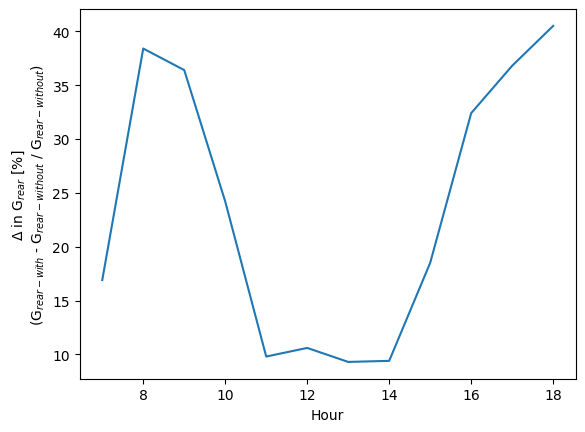

In [28]:
plt.plot(xax,hourly_rearirradiance_comparison)
plt.ylabel('$\Delta$ in G$_{rear}$ [%] \n(G$_{rear-with}$ - G$_{rear-without}$ / G$_{rear-without}$)')
plt.xlabel('Hour')